# LSTM Model for PTB data 
As we concluded before, for PTB data, we apply the following preprocessing:   
resampling: Oversampling \
rescaling: Standard Scaler

If you don't have the original files: run the notebook `preprocessing_ptb_standard_oversampling.ipynb`     
**Input** : the original data.   
ptbdb_normal.csv  
ptbdb_abnormal.csv  

Output: DNN model trained  
model_lstm_ptb.pkl  

In [1]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


## Read data 


In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline  # Use ImbPipeline for oversampling
import matplotlib.pyplot as plt
import seaborn as sns


RawFiles = dict({
    'train': data_path + 'ptb_train_standard_oversampling.csv', 
    'test': data_path + 'ptb_test_standard_oversamling.csv'  
})

OutputFiles = dict({
    'model': model_output_path +  'model_lstm_ptb.pkl'
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



In [3]:
X_train.shape

(16809, 187)

# LSTM with Standard Scaler and Oversampling

In [4]:
# Convert DataFrames to NumPy arrays
X_train = X_train.values
X_test = X_test.values

# Reshape the data to fit the LSTM model (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Check the shape of the data
print("X_train shape:", X_train.shape)  # should be (samples, timesteps, features)
print("X_test shape:", X_test.shape)    # should be (samples, timesteps, features)


X_train shape: (16809, 187, 1)
X_test shape: (4203, 187, 1)


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input 
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adamax, Adam

# Set random seed for reproducibility
tf.random.set_seed(42)

# Define model
model = Sequential()  

# Input Layer
model.add(Input(shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(LSTM(187, activation='relu', return_sequences=True))

# Hidden layers:
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(16, activation='relu', return_sequences=False))

# Output Layer for binary classification of the target
model.add(Dense(1, activation='sigmoid'))  

# Choose an optimizer: 
optimizer = Adamax(learning_rate=0.01)  

# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# binary_crossentropy is used for binary classification problems
model.summary()

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.01)  

# Callbacks for plotting
train_loss = []  
val_loss = []
train_accuracy = []
val_accuracy = []

# Define batch size
batch_size = 64

# Training
epochs = 50
for epoch in range(epochs):
    history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, validation_data=(X_test, y_test), 
                        verbose=0, callbacks=[early_stopping, lr_scheduler])
    
    # Append metrics to the respective lists
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    train_accuracy.append(history.history['accuracy'][0])
    val_accuracy.append(history.history['val_accuracy'][0])
    
    # Print progress at each 10th epoch for feedback
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
              f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 187, 187)       │       141,372 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 187, 64)        │        64,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 16)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,085 (824.55 KB)

 Trainable params: 211,085 (824.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 10/50 - Loss: 0.7000, Val Loss: 0.7002, Accuracy: 0.5523, Val Accuracy: 0.6103
Epoch 20/50 - Loss: 0.6908, Val Loss: 0.6920, Accuracy: 0.5399, Val Accuracy: 0.4996
Epoch 30/50 - Loss: 0.6921, Val Loss: 0.6915, Accuracy: 0.5833, Val Accuracy: 0.5924
Epoch 40/50 - Loss: 0.6906, Val Loss: 0.6917, Accuracy: 0.5093, Val Accuracy: 0.5011
Epoch 50/50 - Loss: 0.6911, Val Loss: 0.6922, Accuracy: 0.5063, Val Accuracy: 0.4992


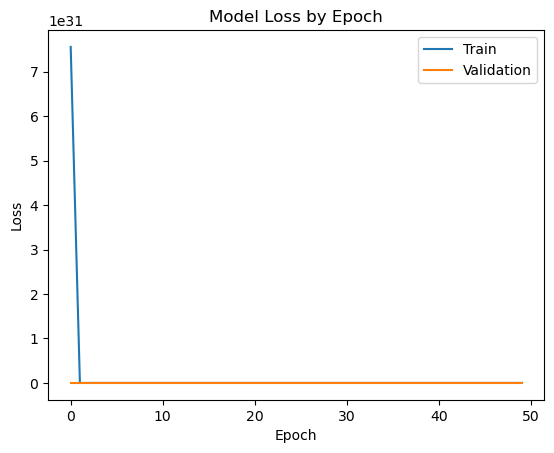

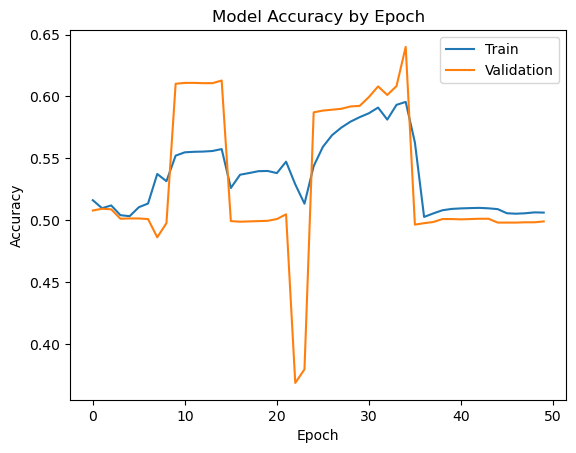

132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step
[[2087    0]
 [2105   11]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2087
           1       1.00      0.01      0.01      2116

    accuracy                           0.50      4203
   macro avg       0.75      0.50      0.34      4203
weighted avg       0.75      0.50      0.34      4203

F1 Score: 0.010343206393982134


In [7]:
# Plotting the Loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the Accuracy
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Making predictions
y_pred = model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)

# Evaluating the model
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))
print(f"F1 Score: {f1_score(y_test, y_pred_class)}")